# A fault and topography mesh of the South America subduction zone.

In the TDEs + Topography post, I used a mesh of the South America subduction zone. In this post, I thought it'd be fun to explain how I built that mesh.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

## Looking at the fault model.

First off, I'm not going to explain how to build the fault geometry. That's already been built! I'm using the same triangular subduction zone mesh used by [Shannon Graham in her Global Block model papers](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2017GC007391). That mesh was built using the [Slab 1.0 subduction zone contours](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2011JB008524). 

```{margin} 
The link in the Slab 1.0 paper is dead and the [first Google search for Slab 1.0 is a portable cutting board](https://store.overlandbound.com/products/slab): "Who knew the cutting surface industry needed disrupting?  And disrupt it, the SLAB 1.0 does."
```

I'll load the mesh up from the `.mat` file (a Matlab file format) and plot it.

In [2]:
file = scipy.io.loadmat("south_america_50km_mod_ext.mat")
fault_pts = file["c"]
fault_pts[:, 0] -= 360
fault_pts[:, 2] *= 1000
fault_tris = file["v"] - 1

I'm also going to plot the sign of vertical component of the normal vector just to check that all the triangles in the mesh are aligned in the same direction.

In [3]:
from cutde.geometry import compute_normal_vectors

normals = compute_normal_vectors(fault_pts[fault_tris])

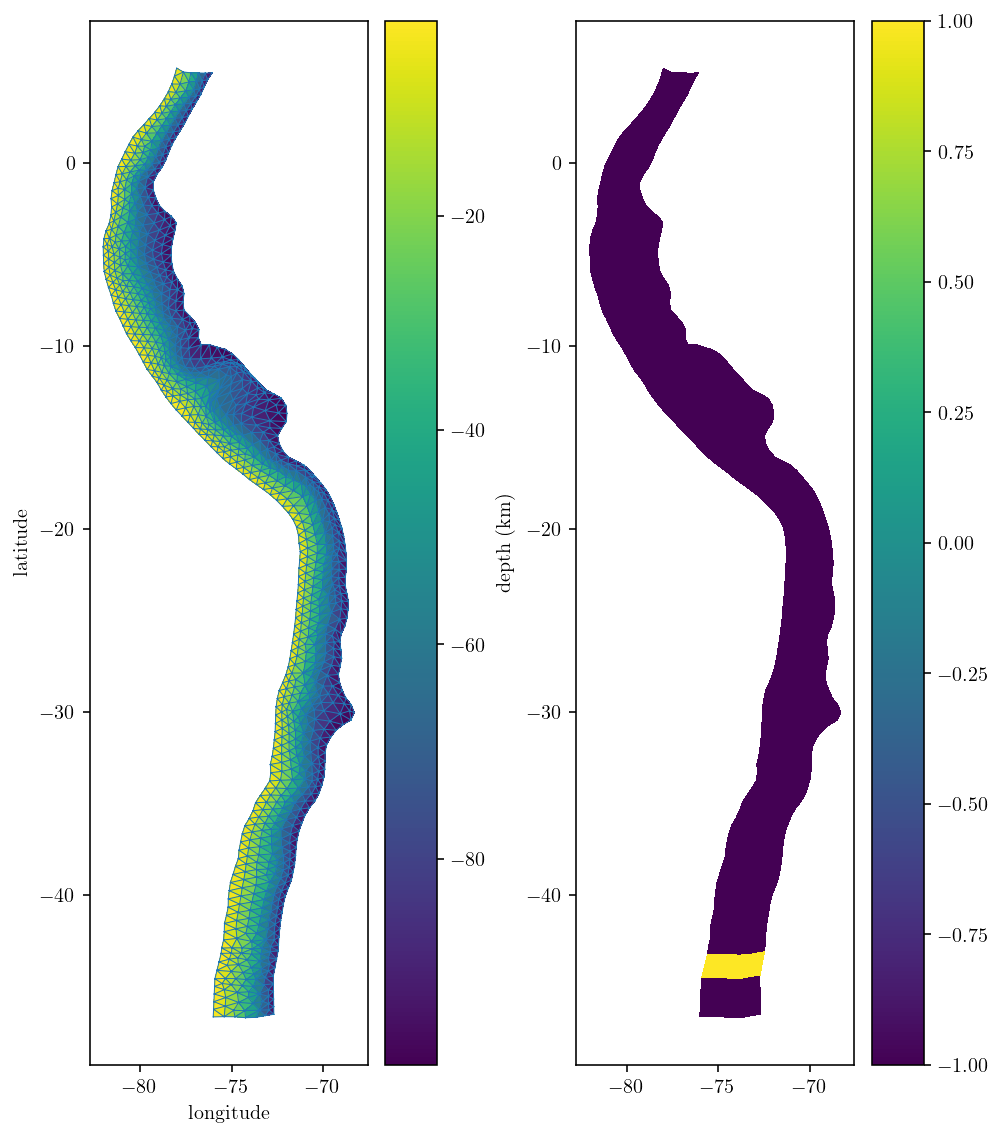

In [4]:
plt.figure(figsize=(7, 8))
plt.subplot(1, 2, 1)
tripc = plt.tripcolor(
    fault_pts[:, 0],
    fault_pts[:, 1],
    fault_tris,
    fault_pts[:, 2] / 1000.0,
    linewidth=0.5,
)
plt.triplot(fault_pts[:, 0], fault_pts[:, 1], fault_tris, linewidth=0.5)
cbar = plt.colorbar()
cbar.set_label("depth (km)")
plt.xlim([np.min(fault_pts[:, 0]), np.max(fault_pts[:, 0])])
plt.axis("equal")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.subplot(1, 2, 2)
plt.tripcolor(fault_pts[:, 0], fault_pts[:, 1], fault_tris, np.sign(normals[:, 2]))
plt.colorbar()
plt.xlim([np.min(fault_pts[:, 0]), np.max(fault_pts[:, 0])])
plt.axis("equal")
plt.tight_layout()
plt.show()

The mesh itself looks great at first glance! But, there is a mild problem with the element orientations at the southern end of the fault mesh. They don't match the rest of the mesh. To fix the issue I can flip the triangle vertex ordering. Instead of ordering the vertices of a given triangle 0-1-2, I can flip the normal vector by ordering them 0-2-1. I'm actually going to flip the orientation of all the dark blue parts of the mesh since it's a bit nicer to follow the convention that dipping fault normal vectors point upwards. This convention results in an upwards-pointing dip vector which is consistent with the upwards dip-vector found in Okada though it is inconsistent with the normal geological convention where the dip vector points downwards.

In [5]:
flip_indices = np.where(normals[:, 2] < 0)
flag = np.zeros_like(normals[:, 0])
flag[flip_indices] = 1

flipped_tris = fault_tris.copy()
flipped_tris[flip_indices, 1] = fault_tris[flip_indices, 2]
flipped_tris[flip_indices, 2] = fault_tris[flip_indices, 1]
fault_tris = flipped_tris

## Refining the fault mesh

Depending on the situation, it might be nice to refine the fault mesh for more accuracy. A simple approach is to split each triangle into four new triangles based on the midpoints of each edge.

In [6]:
v0 = fault_pts[fault_tris[:, 0]]
v1 = fault_pts[fault_tris[:, 1]]
v2 = fault_pts[fault_tris[:, 2]]

In [7]:
v01 = 0.5 * (v0 + v1)
v02 = 0.5 * (v0 + v2)
v12 = 0.5 * (v1 + v2)

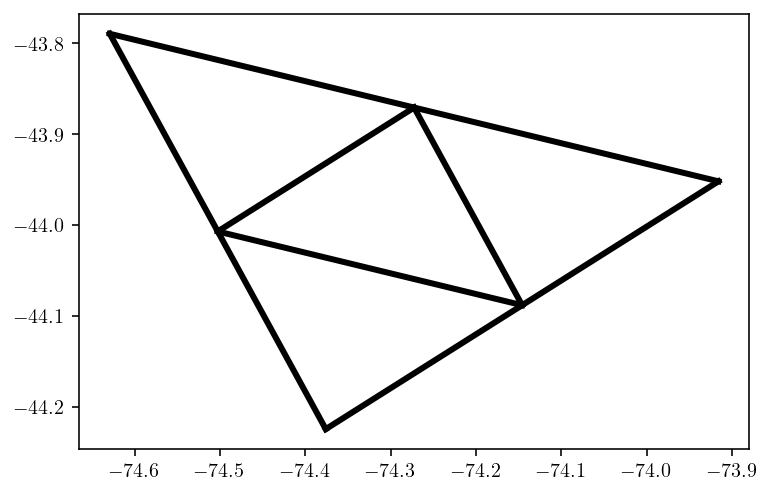

In [8]:
def plot_edge(a, b):
    P = np.array([a[0], b[0]])
    plt.plot(P[:, 0], P[:, 1], "k-")


plot_edge(v0, v1)
plot_edge(v2, v1)
plot_edge(v2, v0)
plot_edge(v01, v12)
plot_edge(v01, v02)
plot_edge(v12, v02)

In [9]:
new_pts = np.concatenate([fault_pts, v01, v02, v12])
v01_idxs = fault_pts.shape[0] + 0 * v01.shape[0] + np.arange(v01.shape[0])
v02_idxs = v01_idxs + v01.shape[0]
v12_idxs = v01_idxs + 2 * v01.shape[0]

In [10]:
import mesh_fncs

new_tris = np.array(
    [
        [fault_tris[:, 0], v01_idxs, v02_idxs],
        [fault_tris[:, 1], v12_idxs, v01_idxs],
        [fault_tris[:, 2], v02_idxs, v12_idxs],
        [v01_idxs, v12_idxs, v02_idxs],
    ]
)
new_tris = np.transpose(new_tris, (2, 0, 1)).reshape((-1, 3))
# fault_pts, fault_tris = mesh_fncs.remove_duplicate_pts((new_pts, new_tris))

## Downloading DEM data

Now, let's add surface topography and Earth curvature to this geometry. Why? Because, we can! And because we're interested in the influence of realistic geometry. Also, I'll end up projecting to geocentric coordinates where (X, Y, Z) = (0, 0, 0) is the center of the Earth. 

Let's start by Long ago I was using Mapzen for easily downloading DEM data. But Mapzen has gone out of business. So, I was sad and forlorn and had no easy source of DEM data... Until I discovered that Mapzen had [exported their entire terrain tiles dataset to Amazon S3!](https://aws.amazon.com/public-datasets/terrain/). So, I replaced the old Mapzen API with some calls to AWS S3 using `boto3`. The basic API call is

``` python
def download_file(x, y, z, save_path):
    BUCKET_NAME = 'elevation-tiles-prod'
    KEY = 'geotiff/{z}/{x}/{y}.tif'.format(x = x, y = y, z = z)

    s3 = boto3.resource('s3')

    try:
        bucket = s3.Bucket(BUCKET_NAME)
        bucket.download_file(KEY, save_path)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
```

I've wrapped this in a more advanced set of functions that allow passing a longitude-latitude bounding box and downloading the necessary files to create an interpolated digital elevation map.

Let's load up the module that does the DEM collection and just test out the tools. There are two relevant parameters: `zoom` determines the resolution of the DEM data. I'm grabbing a pretty large area of data, so I use a low zoom level of 2. And `n_dem_interp_pts` determines how many interpolation points are used to interpolate the DEM to our exact desired locations from the nearby provided coordinates.

downloading dem data for bounds = [-51.875283536, -83.3826, 10.333847175999999, -66.93539999999999] and zoom = 2
10.333847175999999 -83.3826
-51.875283536 -66.93539999999999


Combining 2 into dem_download/raw_merc.tif ...


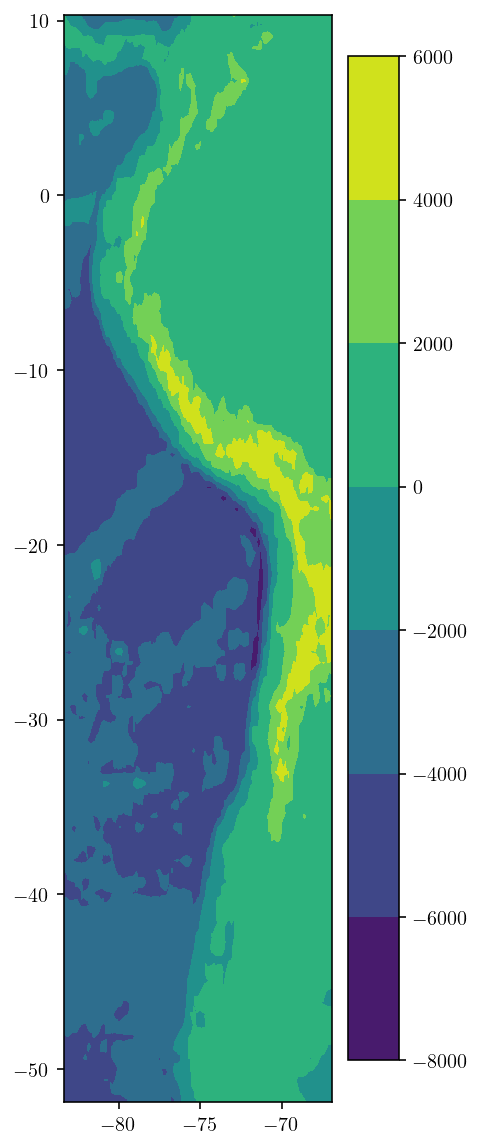

In [11]:
import collect_dem

n_dem_interp_pts = 100
zoom = 2

bounds = collect_dem.get_dem_bounds(fault_pts)
dem_lon, dem_lat, dem = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

plt.figure(figsize=(3, 10))
plt.tricontourf(dem_lon, dem_lat, dem)
plt.colorbar()
plt.show()

## Building the surface mesh.

The next step is to build the surface mesh. However, not just any surface mesh. I need a surface mesh that "conforms" to the fault trace. To be precise, any fault mesh edge that intersects the surface should also be an edge in the surface mesh. 

To do this, I'll first identify the outer edges of the fault. This `mesh_fncs` module has a few handy functions for working with fault meshes like the `get_boundary_loop` function which returns the external edges of a surface mesh.

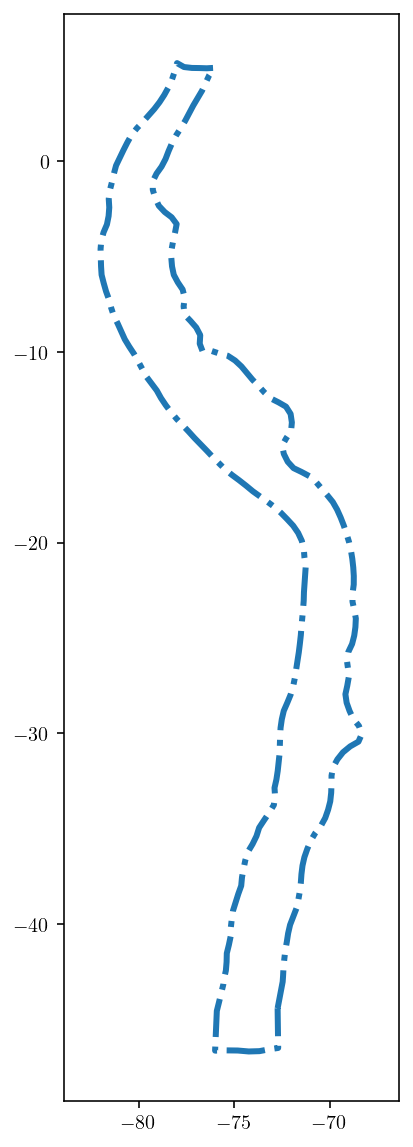

In [12]:
import mesh_fncs

boundary_loop = mesh_fncs.get_boundary_loop((fault_pts, fault_tris))[0]
plt.figure(figsize=(3, 10))
plt.plot(fault_pts[boundary_loop, 0], fault_pts[boundary_loop, 1], "-.")
plt.axis("equal")
plt.show()

And then, just via trial and error, I found that boundary loop indices 130-258 correspond to the surface edges. This is demonstrated just by plotting those edges in the figure below where we looking from the side at the fault.

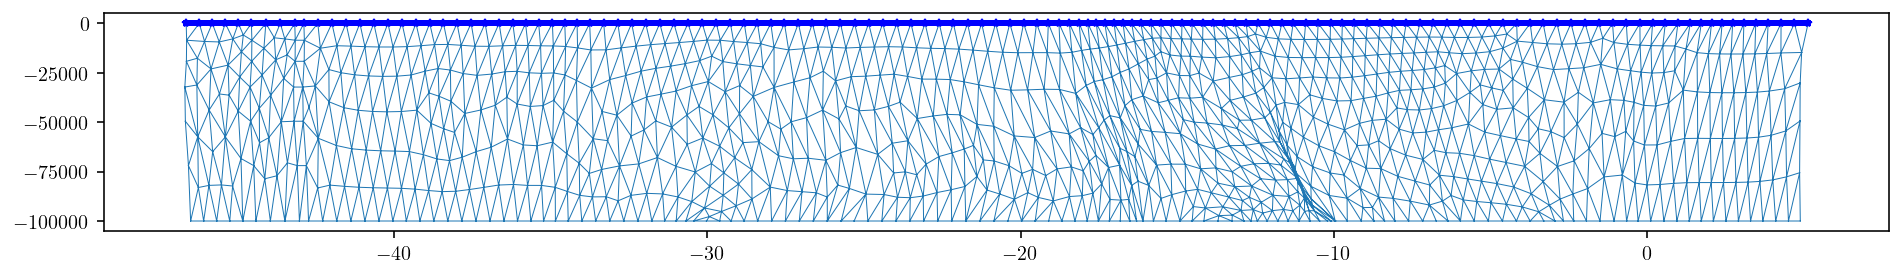

In [13]:
plt.figure(figsize=(16, 2.0))
upper_edge_idxs = boundary_loop[130:258]
# If we had refined the mesh above, this line will provide the
# correct upper_edge_idxs
# upper_edge_idxs = boundary_loop[259:514]
upper_edge_pts = fault_pts[upper_edge_idxs, :]
upper_edge_pts.shape
plt.plot(
    fault_pts[upper_edge_idxs, 1], fault_pts[upper_edge_idxs, 2], "b-*", markersize=4
)
plt.triplot(fault_pts[:, 1], fault_pts[:, 2], fault_tris, linewidth=0.5)
plt.show()

Next, we're going to use `pygmsh` to interface with Gmsh and build our mesh. I'll put some inline comments to explain what's going on.

**Note**: I'm using `pygmsh` version 6.1.1 here.

In [14]:
import pygmsh

geom = pygmsh.built_in.Geometry()

# First, I'll figure out the area that I want to produce a surface mesh for.
# The center of the area will be the center of the fault.
surf_center = np.mean(upper_edge_pts, axis=0)
# And I also want to know the furthest that any fault mesh point is from that center point.
# This is essentially the fault "half-length"
fault_L = np.max(np.sqrt(np.sum((upper_edge_pts - surf_center) ** 2, axis=1)))
# The "half-width" of the surface mesh will be 1.5 times the fault half-length
w = fault_L * 1.5

# And the typical element length-scale will about one tenth the fault length.
# This length scale will only be relevant far from the fault. Near the fault,
# the length of the fault edges will force surface elements to be much smaller.
mesh_size_divisor = 4
mesh_size = fault_L / mesh_size_divisor

# The main polygon of the mesh is a big square.
surf_corners = np.array(
    [
        [surf_center[0] - w, surf_center[1] - w, 0],
        [surf_center[0] + w, surf_center[1] - w, 0],
        [surf_center[0] + w, surf_center[1] + w, 0],
        [surf_center[0] - w, surf_center[1] + w, 0],
    ]
)
surf = geom.add_polygon(surf_corners, mesh_size)

# Now, I'll add the fault trace edge points.
gmsh_pts = dict()
for i in range(upper_edge_pts.shape[0]):
    gmsh_pts[i] = geom.add_point(upper_edge_pts[i], mesh_size)

# And this chunk of code specifies that those edges should be
# included in the surface mesh.
for i in range(1, upper_edge_pts.shape[0]):
    line = geom.add_line(gmsh_pts[i - 1], gmsh_pts[i])

    # pygmsh didn't support this elegantly, so I just insert manual gmsh code.
    intersection_code = "Line{{{}}} In Surface{{{}}};".format(line.id, surf.surface.id)
    geom.add_raw_code(intersection_code)

Finally, build the geometry and can generate the surface mesh.

In [15]:
mesh = pygmsh.generate_mesh(geom, dim=2)

Info    : Running 'gmsh -2 /tmp/tmph90k_b5x.geo -format msh -bin -o /tmp/tmpx_4d2miw.msh' [Gmsh 4.6.0, 1 node, max. 1 thread]
Info    : Started on Sat Jun 12 17:51:59 2021
Info    : Reading '/tmp/tmph90k_b5x.geo'...
Info    : Done reading '/tmp/tmph90k_b5x.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing

Let's plot the resulting mesh. The output format is from the `meshio` package.

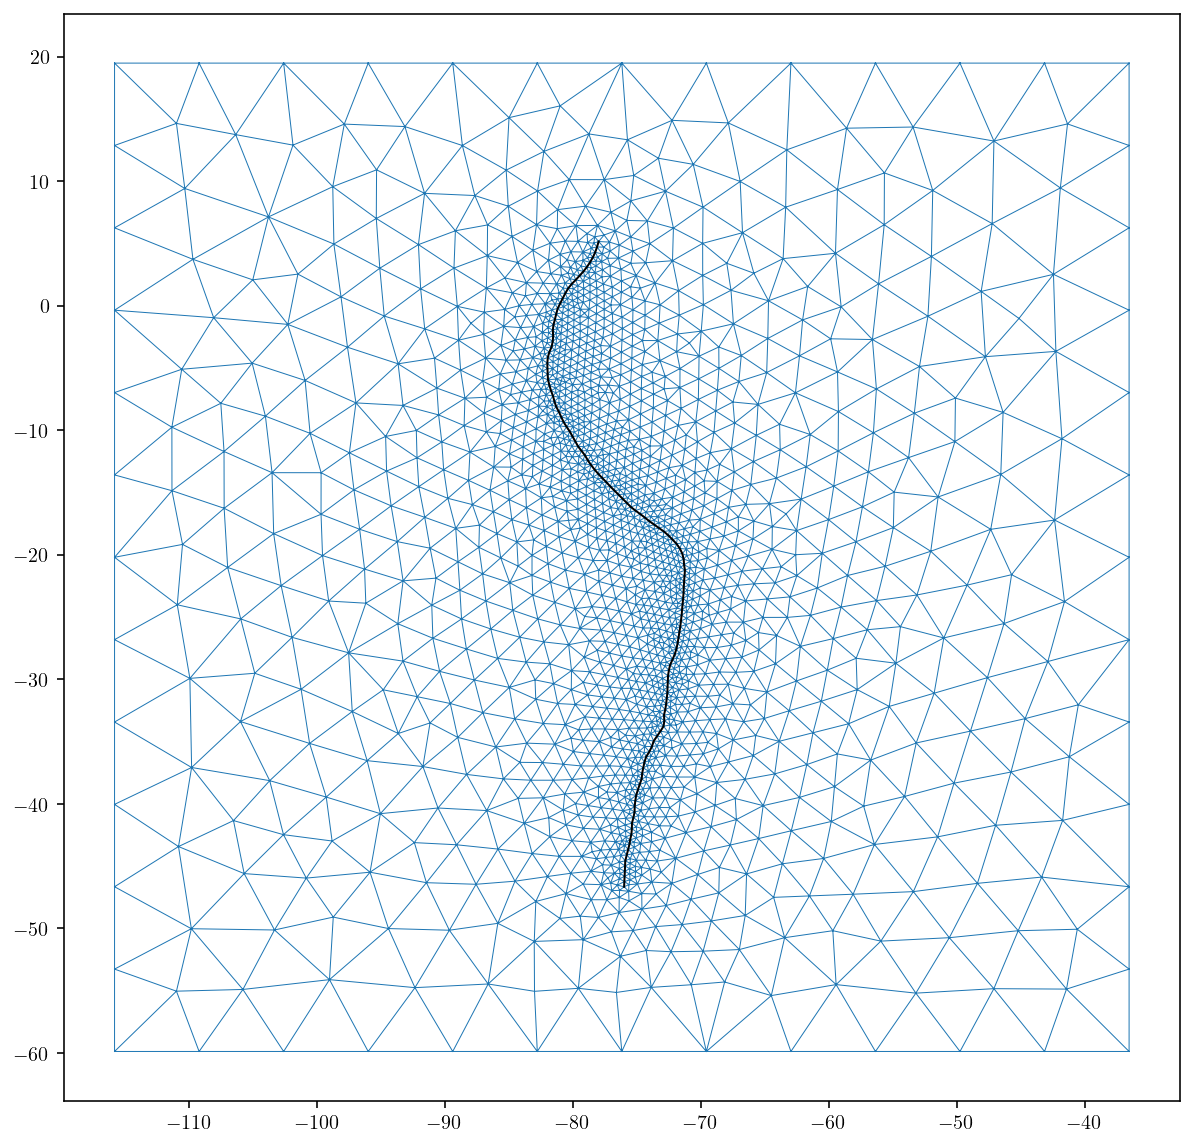

In [16]:
surf_pts = mesh.points
surf_tris = mesh.cells_dict["triangle"]

plt.figure(figsize=(10, 10))
plt.triplot(surf_pts[:, 0], surf_pts[:, 1], surf_tris, linewidth=0.5)
plt.plot(
    upper_edge_pts[:, 0], upper_edge_pts[:, 1], "k-", linewidth=1.0
)  # , markersize = 2)
vW = 1.1 * w
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

Great, that's exactly what I was going for. A mesh that conforms to the fault trace and also gets smoothly coarser moving away from the fault trace. 

The final step is to set elevation: 

* the elevation for the surface mesh. It's currently zero everywhere.
* I also offset the fault model based on the surface elevation since the Slab 1.0 models are defined in terms of depth below the surface.

Note that because we use the same DEM data for computing surface and fault elevations, that the fault trace and the surface edges will precisely match. Using different DEM data for each mesh is a common error here that will result in gaps that may or may not matter depending on the end goal.

In [17]:
bounds = collect_dem.get_dem_bounds(surf_pts)
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

surf_pts[:, 2] = scipy.interpolate.griddata(
    (LON, LAT), DEM, (surf_pts[:, 0], surf_pts[:, 1])
)
fault_pts[:, 2] += scipy.interpolate.griddata(
    (LON, LAT), DEM, (fault_pts[:, 0], fault_pts[:, 1])
)

downloading dem data for bounds = [-67.80746557203787, -123.7930824435223, 27.407324315006626, -28.5782925564778] and zoom = 2
27.407324315006626 -123.7930824435223
-67.80746557203787 -28.5782925564778


Combining 6 into dem_download/raw_merc.tif ...


And I'll make a simple plot of the final mesh. Looks good!

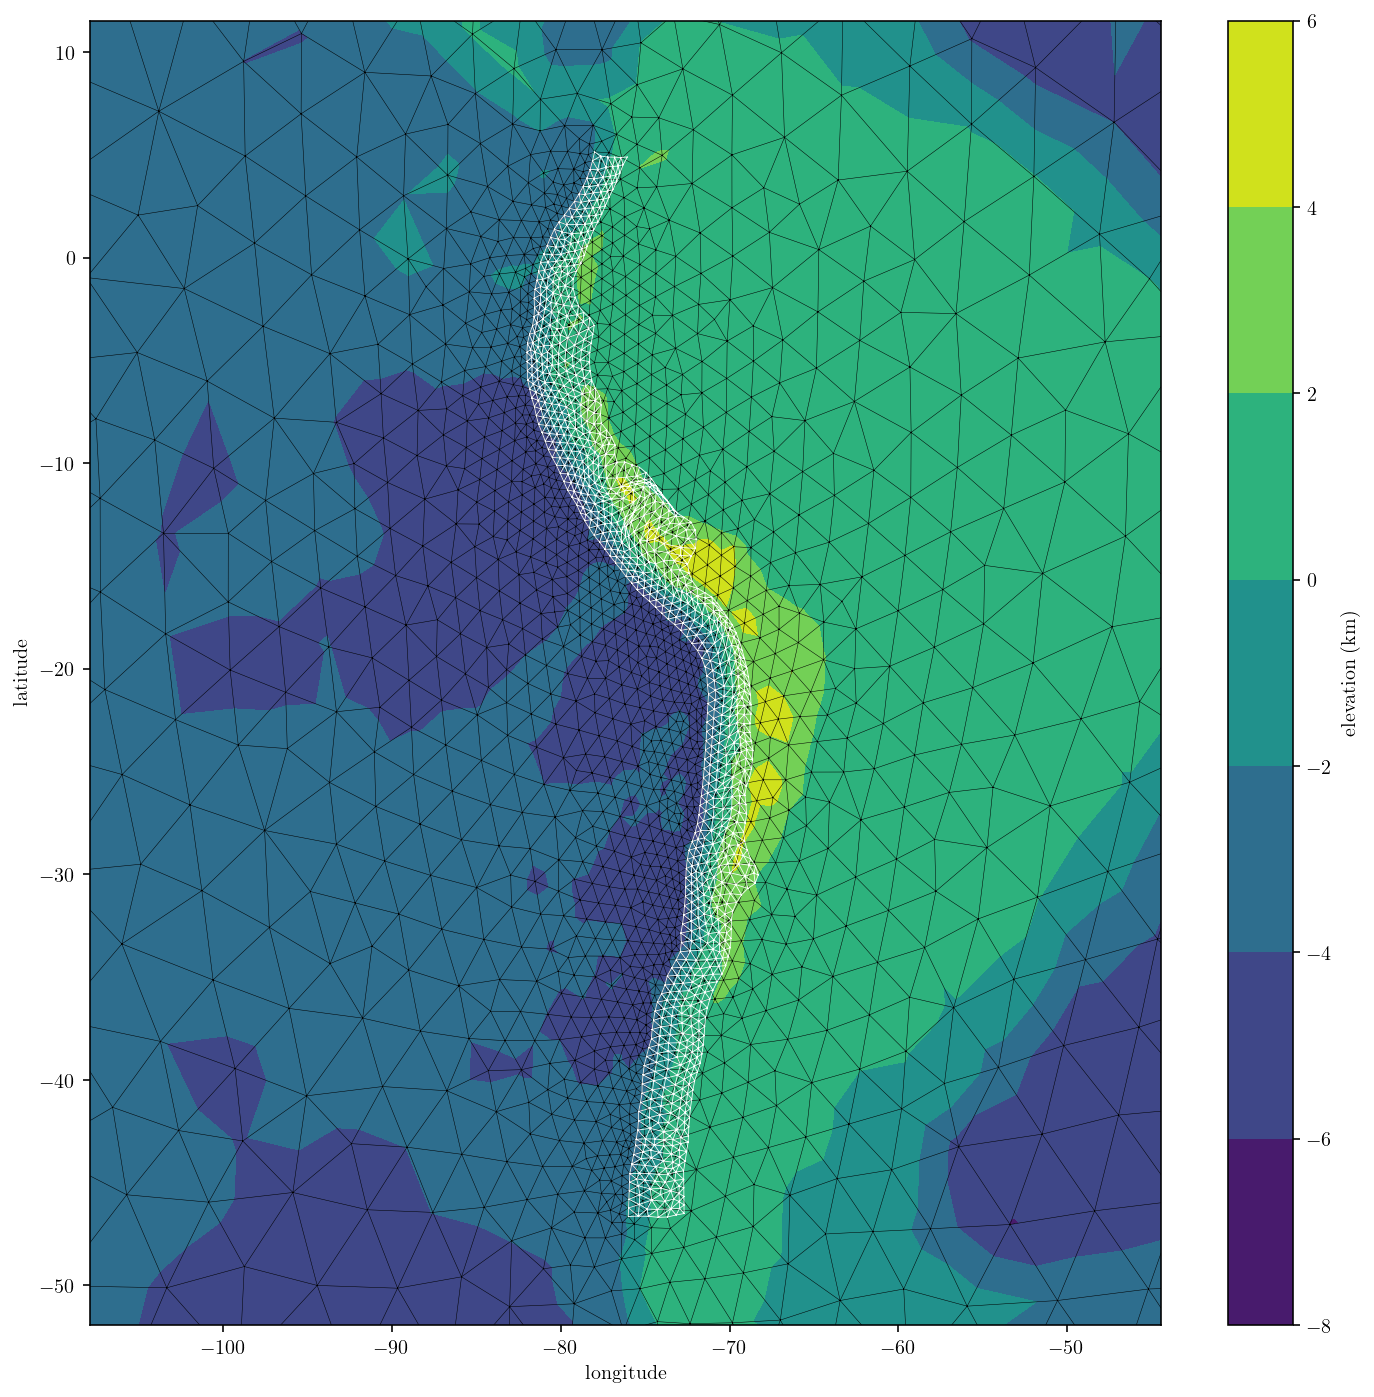

In [18]:
plt.figure(figsize=(12, 12))
cntf = plt.tricontourf(
    surf_pts[:, 0], surf_pts[:, 1], surf_tris, surf_pts[:, 2] / 1000.0
)
plt.triplot(surf_pts[:, 0], surf_pts[:, 1], surf_tris, "k-", linewidth=0.25)
plt.triplot(fault_pts[:, 0], fault_pts[:, 1], fault_tris, "w-", linewidth=0.4)
vW = 1.2 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
cbar = plt.colorbar()
cbar.set_label("elevation (km)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

Let's zoom in on an longitude-z plane approximate cross section of the fault and surface to check that the fault trace and surface match up. The big red dot is a fault mesh point while the blue stars show the points in the cross section from the surface mesh.

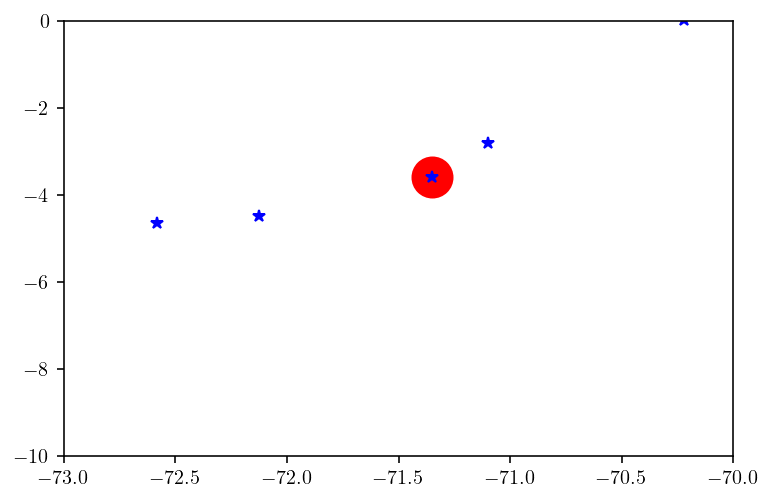

In [19]:
idxs = (fault_pts[:, 1] < -20) & (fault_pts[:, 1] > -20.5)
plt.plot(fault_pts[idxs, 0], fault_pts[idxs, 2] / 1000.0, "ro", markersize=20)
idxs = (surf_pts[:, 1] < -20) & (surf_pts[:, 1] > -20.5)
plt.plot(surf_pts[idxs, 0], surf_pts[idxs, 2] / 1000.0, "b*")
plt.xlim([-73, -70])
plt.ylim([-10, 0])
plt.show()

Awesome! The mesh is ready to use and I'll save it to disk for safe-keeping.

In [20]:
np.save(
    f"sa_mesh{mesh_size_divisor}_{fault_tris.shape[0]}.npy",
    np.array([(surf_pts, surf_tris), (fault_pts, fault_tris)], dtype=object),
)